In [ ]:
from pandas import DataFrame
from pandas import concat
from pandas import read_excel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from statsmodels.graphics.tsaplots import plot_pacf
from tensorflow import keras

# Convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return array(diff)

def prepare_data(series, n_test, n_lag, n_seq):
    # Extract raw values
    raw_values = series.values
    # Difference data to make it stationary
    diff_series = difference(raw_values, 1)
    # Rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_series.reshape(-1, 1))
    print(max(diff_series))
    print(min(diff_series))
    # Transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # Split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    # Inverse transform test set to get original values
    test_values = scaler.inverse_transform(test[:, :])[:, 0]  # Extract actual values

    return scaler, train, test, test_values  # Return all needed data




def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # Assume train, n_lag, nb_epoch, n_batch are defined elsewhere
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], n_lag, 1)  # Reshape X for LSTM
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X.shape[1], X.shape[2]),unroll=True)) # Remove batch_input_shape
    #model.add(Dense(y.shape[1],'tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=0)
    return model
# Fit an LSTM network to training data
#def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
#    # Assume train, n_lag, nb_epoch, n_batch are defined elsewhere
#    X, y = train[:, 0:n_lag], train[:, n_lag:]
#    X = X.reshape(X.shape[0], n_lag, 1)  # Reshape X for LSTM
#
#    # design network
#    model = Sequential()
#    model.add(LSTM(n_neurons, batch_input_shape=(n_batch,X.shape[1], X.shape[2]),unroll=True))
#    #model.add(Dense(y.shape[1],'tanh'))
#    model.compile(loss='mean_squared_error', optimizer='adam')
#
#    # Model summary
#    model.summary()
#
#    # Fit network
#    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, shuffle=False, validation_split=0.1)
#    return model

# Make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # Reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, len(X), 1)  # Ensure there's one feature per timestep
    # Make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # Convert to array
    return [x for x in forecast[0, :]]

# Evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # Make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # Store the forecast
        forecasts.append(forecast)
    return forecasts

# Invert differenced forecast
def inverse_difference(last_ob, forecast):
    # Invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# Inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # Create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # Invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # Invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # Store
        inverted.append(inv_diff)
    return inverted

# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # Plot the entire dataset in blue
    pyplot.plot(series.values)
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # Show the plot
    pyplot.show()

# Load dataset
series = read_excel("TorqueData_noFriction_NL_NG.xlsx", header=None, index_col=0)
# Configure
n_lag = 5
n_seq = 1
n_test = round(0.3 * len(series))  # Or whatever number of tests you want
n_epochs = 20  # Number of epochs for training
n_batch = 1  # Batch size
n_neurons = 2  # Number of neurons in the LSTM layer
pyplot.plot(series.values)
# Prepare data
scaler, train, test,test_values = prepare_data(series, n_test, n_lag, n_seq)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

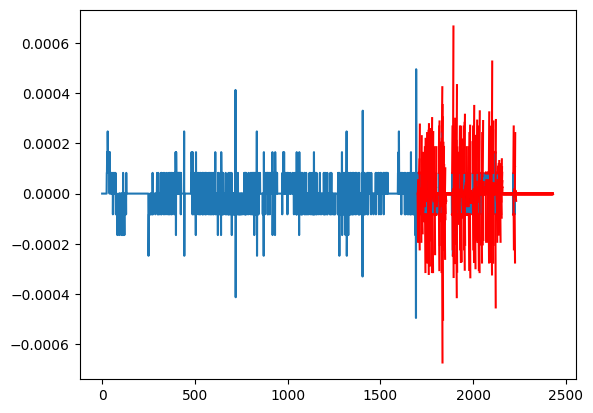

In [11]:

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
model.save('LSTMMM2.keras') # Add .keras extension to the filename
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts_diff=forecasts
# inverse transform forecasts and test

forecasts = inverse_transform(series, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test)


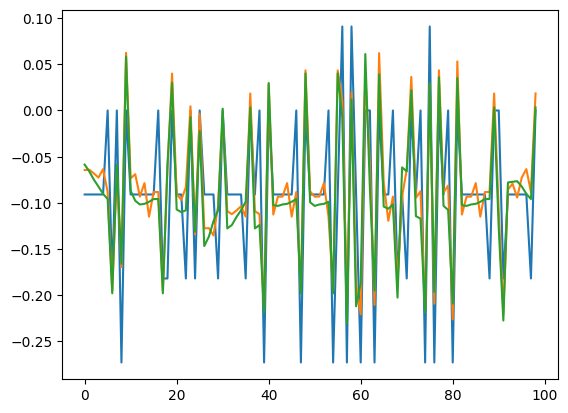

In [12]:
actual = [row[n_lag:] for row in test]
pyplot.plot(actual[1:100])
pyplot.plot(forecasts_diff[1:100])


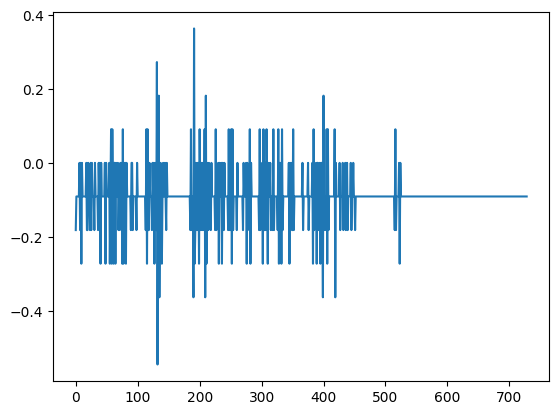

In [13]:
pyplot.plot(actual)

In [14]:
#import numpy as np
##forecast_plot = array(forecasts[:][0]).flatten()
#forecast_plot = [row[0][0] for row in forecasts] # The first number is to select the lag value
#actual_plot = array(actual).flatten()
#actual_series= series.values
#actual_series=actual_series[len(series)-n_test:]
#
#pyplot.figure(figsize=(10, 5))
#pyplot.plot(actual_plot[1:100], label='Actual')
#pyplot.plot(forecast_plot[1:100], label='Forecast',color='red')
##pyplot.title('Forecast vs Actual')
#pyplot.xlabel('Time')
#pyplot.ylabel('Scaled torque')
#pyplot.legend()
#pyplot.savefig("Forecast_vs_Actual.svg")
#pyplot.show()
#print(len(actual_plot))
#print(len(actual_series))
#print(len(actual_series))
#np.savetxt("actual.csv", actual_plot[1:100], delimiter=",")
#print(actual_plot[:100])
#

In [22]:


import os
MODELS_DIR = "models"
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'LSTMMM2.keras'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
'''
# Conversion to TF Lite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


'''
import numpy as np
import tensorflow as tf


# ---------------With quantization----------------
def representative_dataset():
    for _ in range(1697+729):
      if _ < 1697:
        data = train[_,:1]
      else:
        data =test[_-1697,:1]
      yield [data.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# 指出我們要執行預測的優化，其中包括量化
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT] # We use default setting to Optimize our model

# 設定我們要量化的方式
## Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # 使用整數量化，將weight跟bias通通改成整數
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8  # 這意味著輸入數據的類型為 8 位整數（signed 8-bit integers），這與整數量化相關
converter.inference_output_type = tf.int8 # 這意味著輸出數據的類型為 8 位整數（signed 8-bit integers），這與整數量化相關
#
## Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert() # convert to tflite model

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

with tf.io.gfile.GFile("model.tflite", 'wb') as f:
   f.write(model_tflite)


INFO:tensorflow:Assets written to: C:\Users\malth\AppData\Local\Temp\tmp94io_72x\assets


INFO:tensorflow:Assets written to: C:\Users\malth\AppData\Local\Temp\tmp94io_72x\assets


Saved artifact at 'C:\Users\malth\AppData\Local\Temp\tmp94io_72x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name='keras_tensor_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2088905673008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088905676000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2088892415168: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\malth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


RuntimeError: tensorflow/lite/kernels/transpose.cc:63 op_context->perm->dims->data[0] != dims (3 != 1)Node number 2 (TRANSPOSE) failed to prepare.

In [ ]:

# Define the file paths
LSTMMM_LITE = 'model.tflite'  # Change this to the actual path of your .tflite model file
LSTMMM_LITE_MICRO = 'LSTMMM2_LITE_MICRO.cc'      # This will be the output file in C source format

# Install xxd for converting the model to a C source file
#!apt-get update
#!apt-get install -qq xxd

# Convert to a C source file
!xxd -i {MODEL_TFLITE} > {LSTMMM_LITE_MICRO}

# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i "s/{REPLACE_TEXT}/g_model/g" {LSTMMM_LITE_MICRO}

# Print the C source file
!cat {LSTMMM_LITE_MICRO}


In [ ]:
# To find the required operations
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get detailed information about each operation used in the model
ops_list = [op['op_name'] for op in interpreter._get_ops_details()]
print("Operations in the model:", ops_list)


TO test the tensorflow lite file


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the TFLite model
tflite_model_file = 'model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict(model_input):
    # Ensure the input is in the correct shape and dtype
    input_data = np.array(model_input, dtype=np.float32).reshape(1, 3, 1)

    # Get input scale and zero point
    input_scale, input_zero_point = input_details[0]['quantization']
    if input_scale != 0.0:
        input_data = input_data / input_scale + input_zero_point
        input_data = input_data.astype(input_details[0]["dtype"])

    # Set the model input
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the inference
    interpreter.invoke()

    # Get the prediction results
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Dequantize the output layer (from integer to float)
    output_scale, output_zero_point = output_details[0]['quantization']
    if output_scale != 0.0:
        output_data = (output_data - output_zero_point) * output_scale
    return output_data

# Assuming you have some test data following the same preprocessing as your training data
# Example test data (replace this with your actual test data)

# Initialize lists to store predictions and actual values
predictions = []
actuals = []

for i in range(0, len(test)):
    X, y = test[i, 0:n_lag], test[i, n_lag:]
    test_input = X.reshape(1, 3, 1)
    pred = predict(test_input).flatten()
    predictions.append(pred)
    actuals.append(y)

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate RMSE and MAE for each signal
rmse_list = []
mae_list = []

# Assuming the predictions and actuals have shape (num_samples, num_signals)
num_signals = predictions.shape[1]
'''
for signal_index in range(num_signals):
    rmse = np.sqrt(mean_squared_error(actuals[:, signal_index], predictions[:, signal_index]))
    mae = mean_absolute_error(actuals[:, signal_index], predictions[:, signal_index])
    rmse_list.append(rmse)
    mae_list.append(mae)
    print(f'Signal {signal_index}: RMSE={rmse}, MAE={mae}')

# Convert lists to arrays for further analysis if needed
rmse_array = np.array(rmse_list)
mae_array = np.array(mae_list)

print("RMSE for each signal:", rmse_array)
print("MAE for each signal:", mae_array)
'''


Model performance validation:


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def Scaling_transformation(X, min_val, max_val):
    MIN=X.min(axis=0)
    MIN=MIN.values
    MAX=X.max(axis=0)
    MAX=MAX.values
    X_std = (X - MIN) / (MAX - MIN)
    X_scaled = X_std * (max_val - min_val) + min_val
    return X_scaled, MIN, MAX

def Inverse_Scaling_transformation(X_scaled, min_val, max_val, MIN, MAX):
    X_std = (X_scaled - min_val) / (max_val - min_val)
    X_original = X_std * (MAX - MIN) + MIN
    return X_original


pred_plot = inverse_transform(series, predictions, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test)
# evaluate forecasts
evaluate_forecasts(actual, pred_plot, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, pred_plot, n_test)
'''
forecasts_not_scaled=Inverse_Scaling_transformation(DataFrame(predictions), -1, 1, -0.00049565,0.00049565)

actual_not_scaled=Inverse_Scaling_transformation(DataFrame(actuals), -1, 1, -0.00049565, 0.00049565)
pyplot.plot(forecasts_not_scaled[1:100])
pyplot.plot(actual_not_scaled[1:100])
'''

## Calculate RMSE and MAE for each signal
#rmse_list = []
#mae_list = []
#
#for col in forecasts_not_scaled.columns:
#    rmse = np.sqrt(mean_squared_error(actual_not_scaled[col], forecasts_not_scaled[col]))
#    mae = mean_absolute_error(actual_not_scaled[col], forecasts_not_scaled[col])
#    rmse_list.append(rmse)
#    mae_list.append(mae)
#    print(f'Signal {col}: RMSE={rmse}, MAE={mae}')
#
## Convert lists to arrays for further analysis if needed
#rmse_array = np.array(rmse_list)
#mae_array = np.array(mae_list)
#
#print("RMSE for each signal:", rmse_array)
#print("MAE for each signal:", mae_array)
#
##inverse_transform(series, list(prediction), scaler, n_test)
#
## Remember this is the differenced data



In [ ]:
#forecast_plot = array(forecasts[:][0]).flatten()
prediction_plot = [row[0][0] for row in pred_plot] # The first number is to select the lag value
actual_plot = array(actual).flatten()

pyplot.figure(figsize=(10, 5))
pyplot.plot(actual_plot[1:100], label='Actual')
pyplot.plot(prediction_plot[1:100], label='Forecast',color='red')
#pyplot.title('Forecast vs Actual')
pyplot.xlabel('Time')
pyplot.ylabel('Scaled torque')
pyplot.legend()
pyplot.savefig("Forecast_vs_Actual.svg")
pyplot.show()

print(actual_plot[1:100])



In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
scaler = MinMaxScaler()
print(scaler.fit(data))
MinMaxScaler()
print("--")
print(scaler.transform(data))
print("--")
print(Scaling_transformation(DataFrame(data), 0, 1))
'''
actual = [row[n_lag:] for row in test]
pyplot.plot(predictions[1:100])
pyplot.plot(actual[1:100])
